In [1]:
import os
import sys
custom_paths = ['../src/', '../cifar-10.1-pytorch/', '../data-copying/', '../PyTorch_CIFAR10/']
for path in custom_paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print(f"Added {os.path.abspath(path)} to path")

Added /nfs/home/cybai/PyTorch-StudioGAN/src to path
Added /nfs/home/cybai/PyTorch-StudioGAN/cifar-10.1-pytorch to path
Added /nfs/home/cybai/PyTorch-StudioGAN/data-copying to path
Added /nfs/home/cybai/PyTorch-StudioGAN/PyTorch_CIFAR10 to path


In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import functools
from importlib import reload
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.special import softmax
import os
import ast
import glob
import pickle

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

import torch
from torch.nn import Parameter as P
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# import custom

import cifar10_models
reload(cifar10_models)

import cifar10_1
reload(cifar10_1)

from data_utils import cifair
reload(cifair)

from metrics.feat_extract_models import alexnet, inception, vgg
reload(alexnet)
reload(inception)
reload(vgg)

from utils import load_checkpoint
reload(load_checkpoint)

from metrics.FID import calculate_frechet_distance

import misc
reload(misc)

import data_copying_tests
reload(data_copying_tests)

from run_infos import runs

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda'
torch.backends.cudnn.benchmark = True

In [4]:
cifar10_classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'trucks']

In [5]:
cifar10_1_dset = cifar10_1.CIFAR10_1_v6('../data/cifar10_1',
                                         transform=transforms.Compose([transforms.ToTensor(),
                                                                       transforms.Normalize(0.5, 0.5)]), 
                                         download=True) # range = [-1, 1]
cifar10_train_dset = datasets.CIFAR10('../data/cifar10', train=True, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifar10_test_dset = datasets.CIFAR10('../data/cifar10', train=False, 
                                      transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(0.5, 0.5)]), 
                                      download=True) # range = [-1, 1]
cifair10_dset = cifair.ciFAIR10('../data/cifair10', train=False,
                                transform=transforms.Compose([transforms.ToTensor(),
                                                              transforms.Normalize(0.5, 0.5)]), 
                                download=True) # range = [-1, 1]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
ref_dsets = {'cifar10_1': cifar10_1_dset, 'cifar10_train': cifar10_train_dset,
                'cifar10_test': cifar10_test_dset, 'cifair10': cifair10_dset}
ref_dls = {k: DataLoader(v, batch_size=50, shuffle=False, num_workers=8, drop_last=False)
           for k, v in ref_dsets.items()}

In [7]:
proj_model = inception.WrappedInception3().eval().to(device)

##### trainable parameters

#####


In [8]:
feats = {}
labels = {}
for dset_name, dl in ref_dls.items():
    (xs_, ys_), feats_, logits_ = misc.project(dl, proj_model, n_samples=None, to_numpy=True)
    # top_1_conf = np.amax(softmax(logits_, axis=-1), axis=-1)
    feats[dset_name] = feats_
    labels[dset_name] = ys_
    print(dset_name, feats_.shape, ys_.shape)

cifar10_1 (2000, 2048) (2000,)
cifar10_train (50000, 2048) (50000,)
cifar10_test (10000, 2048) (10000,)
cifair10 (10000, 2048) (10000,)


In [9]:
dset_inception_means, dset_inception_covs = {}, {}
for dset_name, feat in feats.items():
    dset_inception_means[dset_name] = np.mean(feat, axis=0)
    dset_inception_covs[dset_name] = np.cov(feat, rowvar=False)

In [9]:
nnds, _ = misc.calculate_knnd_numpy(target_feats=feats['cifar10_test'], 
                                    ref_feats=feats['cifar10_train'])
nnds.shape

(10000,)

(array([  7.,  18.,  28.,  17.,  33.,  27.,  39.,  53.,  66.,  97., 115.,
        157., 166., 252., 264., 316., 349., 375., 400., 415., 442., 457.,
        492., 548., 505., 528., 551., 560., 504., 479., 383., 352., 254.,
        232., 158., 122.,  85.,  64.,  29.,  27.,   8.,  12.,   4.,   3.,
          3.,   2.,   0.,   0.,   0.,   2.]),
 array([0.01536971, 0.02144039, 0.02751106, 0.03358173, 0.03965241,
        0.04572308, 0.05179375, 0.05786443, 0.0639351 , 0.07000577,
        0.07607645, 0.08214712, 0.08821779, 0.09428847, 0.10035914,
        0.10642982, 0.11250049, 0.11857116, 0.12464184, 0.13071251,
        0.13678318, 0.14285386, 0.14892453, 0.1549952 , 0.16106588,
        0.16713655, 0.17320722, 0.1792779 , 0.18534857, 0.19141924,
        0.19748992, 0.20356059, 0.20963126, 0.21570194, 0.22177261,
        0.22784328, 0.23391396, 0.23998463, 0.2460553 , 0.25212598,
        0.25819665, 0.26426733, 0.270338  , 0.27640867, 0.28247935,
        0.28855002, 0.2946207 , 0.30069137, 0.

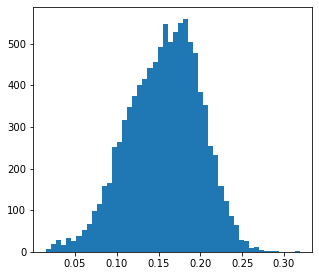

In [10]:
plt.figure(figsize=(5, 4.5))
plt.hist(nnds, bins=50)

### Evaluate quality

##### Calculate Inception metrics

In [11]:
def calculate_inception_metrics(samplers, savefig_fname=None):
    
    # sample images
    print('start sampling images..')
    gen_feats = {}
    gen_probs = {}
    for mrt, samplers_ in samplers.items():
        print(f'mrt={mrt}')
        gen_feats[mrt] = []
        gen_probs[mrt] = []
        for sampler in samplers_:
            _, feats_, probs_ = misc.project(sampler, proj_model, n_samples=10000, to_numpy=True, return_logits=False)
            gen_feats[mrt].append(feats_)
            gen_probs[mrt].append(probs_)
            
    # calculate inception stats
    print('start calculating inception stats..')
    gen_inception_means, gen_inception_covs = {}, {}
    for mrt, gen_feats_ in gen_feats.items():
        gen_inception_means[mrt] = []
        gen_inception_covs[mrt] = []
        for gen_feat in gen_feats_:
            mu = np.mean(gen_feat, axis=0)
            cov = np.cov(gen_feat, rowvar=False)
            gen_inception_means[mrt].append(mu)
            gen_inception_covs[mrt].append(cov)
            
    # FID
    print('start calculating FID..')
    fids = {}
    for dset_name in feats.keys():
        print(f"{dset_name}:", end=' ')
        fids_ = {}
        for mrt in gen_feats.keys():
            fids_[mrt] = []
            print(mrt, end=', ')
            for mu, cov in zip(gen_inception_means[mrt], gen_inception_covs[mrt]):
                fid = calculate_frechet_distance(mu, cov, dset_inception_means[dset_name], 
                                                 dset_inception_covs[dset_name])
                fids_[mrt].append(fid)
        fids[dset_name] = fids_
        print("")
        
    # IS
    print('start calculating IS..')
    IS_means = {}
    IS_stds = {}
    for mrt, gen_probs_ in gen_probs.items():
        IS_means_, IS_stds_ = [], []
        for prob in gen_probs_:
            IS_mean, IS_std = misc.calculate_IS(prob)
            IS_means_.append(IS_mean)
            IS_stds_.append(IS_std)
        IS_means[mrt], IS_stds[mrt] = np.mean(IS_means_), np.mean(IS_stds_)
    
    # plot
    plot_inception_metrics(fids, IS_means, IS_stds, savefig_fname)
    
    return fids, IS_means, IS_stds

def plot_inception_metrics(fids, IS_means, IS_stds, savefig_fname=None):
    x = np.arange(len(IS_means))  # the label locations
    width = 0.7  # the width of the bars
    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
    for (dset_name, fids_), ax in zip(fids.items(), axs.flat):
        rects = ax.bar(x, [np.mean(fid) for fid in fids_.values()], width,
                       yerr=[np.std(fid) for fid in fids_.values()])

        misc.autolabel(rects, ax)
        ax.set_xticks(x)
        ax.set_xticklabels(list(fids_.keys()))
        ax.set_xlabel('mrt')
        ax.set_title(f"FID ({dset_name})")

    ax = axs.flat[-1]
    rects = ax.bar(x, list(IS_means.values()), width, 
                   label='IS', yerr=list(IS_stds.values()))
    misc.autolabel(rects, ax)
    ax.set_title(f"IS")
    ax.set_xticks(x)
    ax.set_xticklabels(IS_means.keys())
    ax.set_xlabel('mrt')

    plt.tight_layout()
    if savefig_fname is not None:
        if not savefig_fname.endswith('.pdf'):
            savefig_fname += '.pdf'
        plt.savefig(savefig_fname, bbox_inches='tight')

start sampling images..
mrt=0.0
mrt=0.1
mrt=0.12
mrt=0.13
mrt=0.14
mrt=0.15
mrt=0.16
start calculating inception stats..
start calculating FID..
cifar10_1: 0.0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 
cifar10_train: 0.0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 
cifar10_test: 0.0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 
cifair10: 0.0, 0.1, 0.12, 0.13, 0.14, 0.15, 0.16, 
start calculating IS..


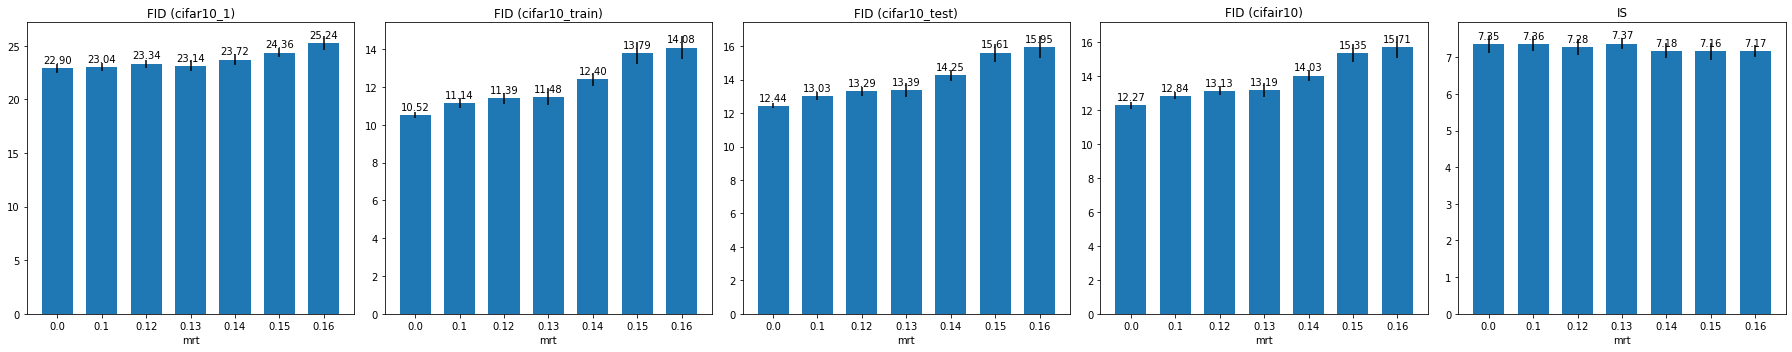

In [13]:
# SAGAN experiments (run in cl8)
samplers = {mrt: [misc.wrapper_best(runname, 'CIFAR10', device=device) for runname in runnames]
            for mrt, runnames in runs['CIFAR10']['sagan'].items()}
fids, IS_means, IS_stds = calculate_inception_metrics(samplers)

In [14]:
np.savez('inception_stats(cifar10_sagan).npz', fids=fids, IS_means=IS_means, IS_stds=IS_stds)

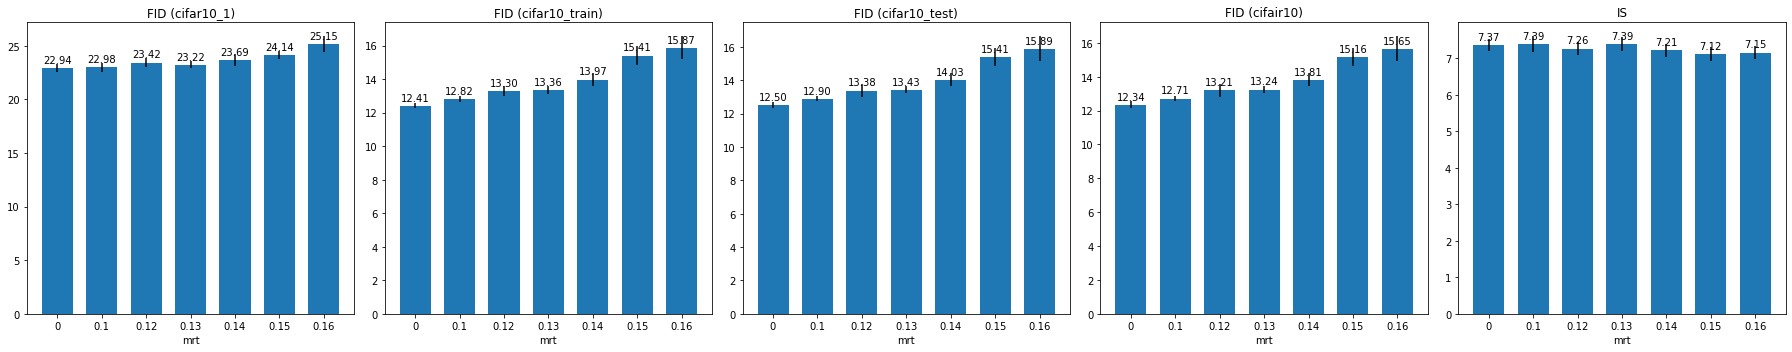

In [15]:
plot_inception_metrics(fids, IS_means, IS_stds) # , savefig_fname='custom_inception_metrics(cifar10_sagan).pdf')

In [ ]:
# diffaug experiments
samplers = {mrt: [misc.wrapper_best(runname, 'CIFAR10', device=device) for runname in runnames]
            for mrt, runnames in runs['CIFAR10']['diffaug'].items()}
fids, IS_means, IS_stds = calculate_inception_metrics(samplers)

start sampling images..
mrt=0.0
mrt=0.1
mrt=0.12
mrt=0.13
mrt=0.14


In [35]:
if os.path.isfile('inception_stats(cifar10_diffaug).npz'):
    with np.load('inception_stats(cifar10_diffaug).npz', allow_pickle=True) as f:
        fids, IS_means, IS_stds = f['fids'].tolist(), f['IS_means'].tolist(), f['IS_stds'].tolist()
else:
    np.savez('inception_stats(cifar10_diffaug).npz', fids=fids, IS_means=IS_means, IS_stds=IS_stds)

In [39]:
for dset_name, fids_ in fids.items():
    print(dset_name)
    for mrt, fid in fids_.items():
        print(f"mrt={mrt:.2f}\t{np.mean(fid):.4f}\t{np.std(fid):.4f}")
print("IS")
for mrt in IS_means.keys():
    print(f"mrt={mrt:.2f}\t{IS_means[mrt]:.4f}\t{IS_stds[mrt]:.4f}")

cifar10_1
mrt=0.00	22.2442	0.1142
mrt=0.10	22.0661	0.1315
mrt=0.12	22.0902	0.1132
mrt=0.13	22.0717	0.1010
mrt=0.14	22.0401	0.2811
mrt=0.15	21.9167	0.0843
mrt=0.16	22.0620	0.2256
cifar10_train
mrt=0.00	5.0804	0.0743
mrt=0.10	5.0971	0.1111
mrt=0.12	5.2992	0.0502
mrt=0.13	5.3416	0.0783
mrt=0.14	5.5440	0.1720
mrt=0.15	5.7565	0.0690
mrt=0.16	6.1428	0.1066
cifar10_test
mrt=0.00	7.1069	0.0778
mrt=0.10	7.1164	0.0840
mrt=0.12	7.3551	0.0692
mrt=0.13	7.3935	0.0632
mrt=0.14	7.5775	0.1749
mrt=0.15	7.7876	0.0784
mrt=0.16	8.1627	0.0875
cifair10
mrt=0.00	7.1883	0.0806
mrt=0.10	7.1771	0.0886
mrt=0.12	7.3994	0.0649
mrt=0.13	7.4382	0.0715
mrt=0.14	7.6020	0.1742
mrt=0.15	7.7827	0.0796
mrt=0.16	8.1448	0.0924
IS
mrt=0.00	8.8592	0.2183
mrt=0.10	8.8657	0.2507
mrt=0.12	8.8533	0.2337
mrt=0.13	8.8750	0.1836
mrt=0.14	8.7467	0.1840
mrt=0.15	8.6937	0.2296
mrt=0.16	8.6536	0.2236


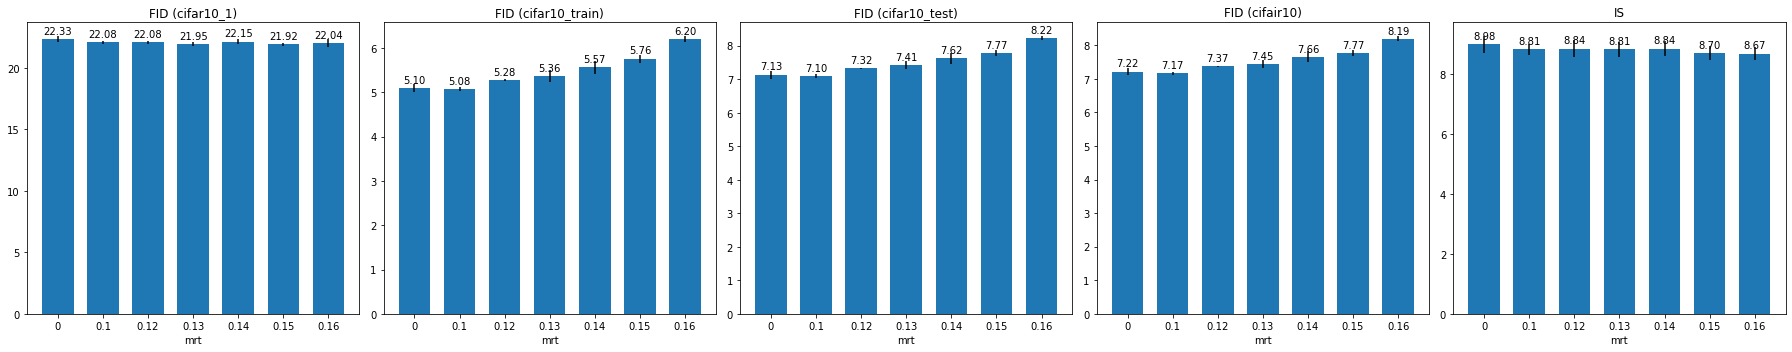

In [24]:
plot_inception_metrics(fids, IS_means, IS_stds) # , savefig_fname='custom_inception_metrics(cifar10_diffaug).pdf')

In [50]:
biggan_stats = {
    'FID_means': {
        'cifar10_1': {0: 22.87, 0.1: 22.91, 0.12: 22.93, 0.13: 22.67, 0.14: 23.17, 0.15: 23.63, 0.16: 23.99},
        'cifar10_train': {0: 6.35, 0.1: 6.54, 0.12: 6.87, 0.13: 6.91, 0.14: 7.55, 0.15: 8.22, 0.16: 8.91},
        'cifar10_test': {0: 8.42, 0.1: 8.62, 0.12: 8.92, 0.13: 8.99, 0.14: 9.61, 0.15: 10.27, 0.16: 10.92},
        'cifair10': {0: 8.48, 0.1: 8.66, 0.12: 8.93, 0.13: 8.98, 0.14: 9.6, 0.15: 10.24, 0.16: 10.86},
    },
    'FID_stds': {
        'cifar10_1': {0: 0.2051983584, 0.1: 0.6874145007, 0.12: 0.2154582763, 0.13: 0.2291381669, 0.14: 0.598495212, 0.15: 0.3248974008, 0.16: 0.4993160055},
        'cifar10_train': {0: 0.2111388196, 0.1: 0.4355777224, 0.12: 0.2610141313, 0.13: 0.2842892768, 0.14: 0.4488778055, 0.15: 0.2909393184, 0.16: 0.4422277639},
        'cifar10_test': {0: 0.1972477064, 0.1: 0.4556574924, 0.12: 0.2645259939, 0.13: 0.2675840979, 0.14: 0.4036697248, 0.15: 0.3119266055, 0.16: 0.4495412844},
        'cifair10': {0: 0.2142857143, 0.1: 0.4741641337, 0.12: 0.2720364742, 0.13: 0.2689969605, 0.14: 0.4224924012, 0.15: 0.2978723404, 0.16: 0.4376899696},
    },
    'IS_means': {0: 8.45, 0.1: 8.37, 0.12: 8.26, 0.13: 8.19, 0.14: 8.14, 0.15: 8.1, 0.16: 8.05},
    'IS_stds': {0: 0.2859903382, 0.1: 0.2898550725, 0.12: 0.2492753623, 0.13: 0.2376811594, 0.14: 0.2608695652, 0.15: 0.2647342995, 0.16: 0.2550724638},
}

In [45]:
sagan_stats = {}
with np.load('inception_stats(cifar10_sagan).npz', allow_pickle=True) as f:
    sagan_stats['FID_means'] = {k: {mrt: np.mean(v_) for mrt, v_ in v.items()} 
                                for k, v in f['fids'].tolist().items()}
    sagan_stats['FID_stds'] = {k: {mrt: np.std(v_) for mrt, v_ in v.items()} 
                               for k, v in f['fids'].tolist().items()}
    sagan_stats['IS_means'], sagan_stats['IS_stds'] = f['IS_means'].tolist(), f['IS_stds'].tolist()

In [46]:
diffaug_stats = {}
with np.load('inception_stats(cifar10_diffaug).npz', allow_pickle=True) as f:
    diffaug_stats['FID_means'] = {k: {mrt: np.mean(v_) for mrt, v_ in v.items()} 
                                for k, v in f['fids'].tolist().items()}
    diffaug_stats['FID_stds'] = {k: {mrt: np.std(v_) for mrt, v_ in v.items()} 
                               for k, v in f['fids'].tolist().items()}
    diffaug_stats['IS_means'], diffaug_stats['IS_stds'] = f['IS_means'].tolist(), f['IS_stds'].tolist()

In [62]:
all_stats = {'SAGAN': sagan_stats, 'BigGAN': biggan_stats, 'BigGAN + DiffAug': diffaug_stats}

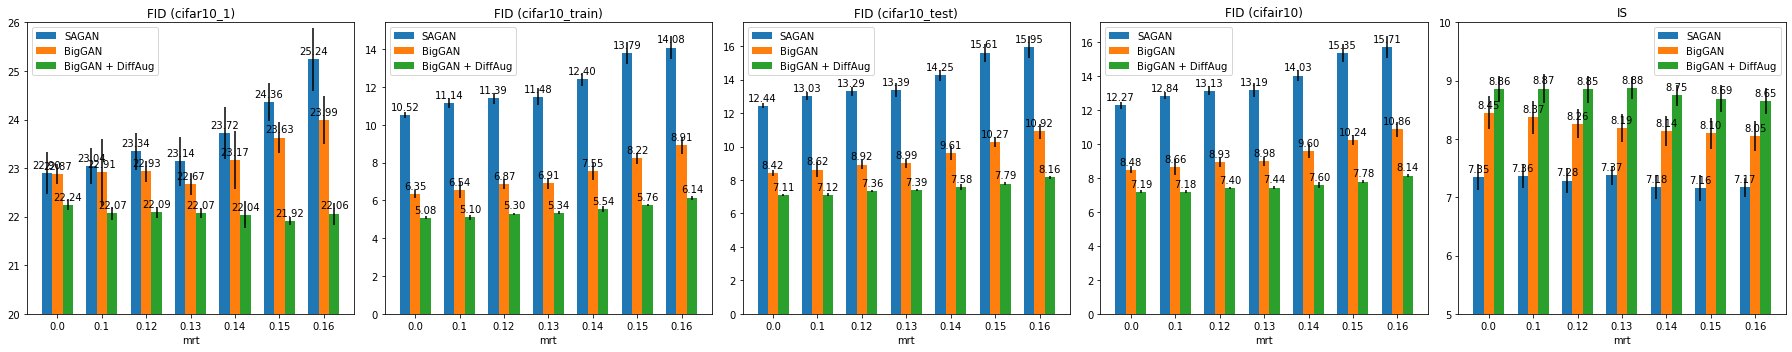

In [81]:
ordered_dsets = ['cifar10_1', 'cifar10_train', 'cifar10_test', 'cifair10']
x = np.arange(7)  # the label locations
width = 0.7 / len(all_stats)  # the width of the bars
x_shifts = np.arange(len(all_stats)) * width - (len(all_stats) - 1) * width / 2
ylims = [(20, 26), (None, None), (None, None), (None, None)]

fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for (model_name, model_stats), x_shift in zip(all_stats.items(), x_shifts):
    for dset_name, ax, ylim in zip(ordered_dsets, axs.flat, ylims):
        rects = ax.bar(x + x_shift, model_stats['FID_means'][dset_name].values(), width,
                       yerr=model_stats['FID_stds'][dset_name].values(), label=model_name)

        misc.autolabel(rects, ax)
        ax.set_xticks(x)
        ax.set_xticklabels(list(model_stats['FID_means'][dset_name].keys()))
        ax.set_xlabel('mrt')
        ax.set_title(f"FID ({dset_name})")
        ax.set_ylim(ylim)
        ax.legend()

ax = axs.flat[-1]
for (model_name, model_stats), x_shift in zip(all_stats.items(), x_shifts):
    rects = ax.bar(x + x_shift, model_stats['IS_means'].values(), width, 
                   label=model_name, yerr=model_stats['IS_stds'].values())
    misc.autolabel(rects, ax)
    ax.set_title(f"IS")
    ax.set_xticks(x)
    ax.set_xticklabels(IS_means.keys())
    ax.set_xlabel('mrt')
    ax.set_ylim(5, 10)
    ax.legend()

fig.tight_layout()
plt.savefig('custom_inception_metrics(cifar10).pdf', bbox_inches='tight')

##### Save sampled images
skip this for now too many images to visualize

In [19]:
bsize = 50
memdists, memdist_indices = {}, {}

for mrt, activations in sampled_inception_activations.items():
    activations_ = activations[0] # only use seed = 0
    memdists_, memdist_indices_ = [], []
    for bstart in range(0, len(activations_['pool']), bsize):
        batch = activations_['pool'][bstart:bstart + bsize]
        batch = torch.from_numpy(batch).float().to(device)
        with torch.no_grad():
            memdist, memdist_index = misc.compute_memorization_distance(batch, real_normed_tensor)
        memdists_.append(memdist.cpu().numpy())
        memdist_indices_.append(memdist_index.cpu().numpy())
    memdists[mrt] = np.concatenate(memdists_, axis=0)
    memdist_indices[mrt] = np.concatenate(memdist_indices_, axis=0)

In [22]:
# random 400 samples, 40 per class (20 x 2)
n_rows, n_cols = 20, 20
padding = 4
n_rows_per_class, n_cols_per_class = 2, 20

for mrt, activations in sampled_inception_activations.items():
    for seed, activations_ in activations.items():
        combined_image = np.zeros([n_rows * 32 + (n_rows - 1) * padding,
                                   n_cols * 32 + (n_cols - 1) * padding,
                                   3])

        for n_class in range(10):

            class_sampled_images = activations_['images'][activations_['labels'] == n_class]
            assert(len(class_sampled_images) >= n_rows_per_class * n_cols_per_class)

            class_sampled_images = class_sampled_images[:n_rows_per_class * n_cols_per_class]

            for cnt, class_sampled_image in enumerate(class_sampled_images):
                start_x = (cnt // n_rows) * (32 + padding) + n_class * (32 + padding) * n_rows_per_class
                start_y = (cnt % n_rows) * (32 + padding)
                combined_image[start_x:start_x + 32, start_y:start_y + 32] = class_sampled_image.transpose(1, 2, 0)

        plt.figure(figsize=(60, 31))
        plt.imshow(combined_image)
        plt.axis('off')
        # plt.savefig(f'image_samples/random_samples/mrt={mrt:.2f}seed{seed}.pdf', bbox_inches='tight')
        plt.close()

In [23]:
for mrt, activations in sampled_inception_activations.items():
    
    for seed, activations_ in activations.items():
    
        combined_images = {}

        for n_class in range(10):
            class_mask = activations_['labels'] == n_class
            class_sampled_images = activations_['images'][class_mask]

            n_rows, n_cols = 7, 7
            padding = 4
            combined_image = np.zeros([n_rows * 32 + (n_rows - 1) * padding,
                                       2 * n_cols * 32 + (n_cols - 1) * padding,
                                       3])
            assert(len(class_sampled_images) >= n_rows * n_cols)

            rank_mask = memdists[mrt][class_mask].argsort().argsort() < n_rows * n_cols
            top_n_indices = np.arange(len(rank_mask)).astype(np.int)[rank_mask]
            top_n_nn_indices = memdist_indices[mrt][class_mask].astype(np.int)[rank_mask]
            assert(len(list(set(top_n_indices))) == len(list(top_n_nn_indices)))

            for cnt, (image_i, nn_i) in enumerate(zip(top_n_indices, top_n_nn_indices)):
                start_x = (cnt % n_rows) * (32 + padding)
                start_y = (cnt // n_rows) * (32 * 2 + padding)

                image = class_sampled_images[image_i].transpose(1, 2, 0)
                nn_image = cifar10_train_dset[nn_i][0].numpy().transpose(1, 2, 0)

                combined_image[start_x:start_x + 32, start_y:start_y + 32] = image
                combined_image[start_x:start_x + 32, start_y + 32:start_y + 64] = (nn_image + 1) / 2

            combined_images[n_class] = combined_image

        fig, axs = plt.subplots(2, 5, figsize=(300, 62))
        for n_class, ax in zip(range(10), axs.flat):
            ax.imshow(combined_images[n_class])
            ax.axis('off')
        plt.tight_layout()
        # plt.savefig(f'image_samples/nearest_neighbor_pairs/mrt={mrt:.2f}seed{seed}.pdf', bbox_inches='tight')
        plt.close()

### Evaluate memorization

###### Calculate C_T

In [12]:
def calculate_C_T(runs, dls, proj_model, train_dset_name='cifar10_train'):
    feats = {}
    labels = {}
    for dset_name, dl in dls.items():
        (xs_, ys_), feats_, logits_ = misc.project(dl, proj_model, n_samples=None, to_numpy=True)
        # top_1_conf = np.amax(softmax(logits_, axis=-1), axis=-1)
        feats[dset_name] = feats_
        labels[dset_name] = ys_
        
    class_stats = {}
    for n_class in range(10):
        print(f"n_class = {n_class}")
        train_pool = feats[train_dset_name][labels[train_dset_name] == n_class]
        
        pca_xf = PCA(n_components=64).fit(train_pool)
        train_pca = pca_xf.transform(train_pool)
        
        class_gen_feats = {}
        for mrt, runs_ in runs.items():
            class_gen_feats_ = []
            for run in runs_:
                sampler = wrapper(run, sample_mode=n_class)
                _, feats_, _ = misc.project(sampler, proj_model, n_samples=10000, 
                                            to_numpy=True, return_logits=False)
                class_gen_feats_.append(feats_)
                del _
            class_gen_feats[mrt] = class_gen_feats_
                
        stats = {}
        for dset_name in feats.keys():

            if dset_name == train_dset_name:
                continue

            n_clusters = min(feats[dset_name].shape[0], train_pool.shape[0]) // 200
            km_clf = KMeans(n_clusters=n_clusters).fit(train_pca)
            T_labels = km_clf.predict(train_pca)

            test_pool = feats[dset_name][labels[dset_name] == n_class]
            
            test_pca = pca_xf.transform(test_pool)
            Pn_labels = km_clf.predict(test_pca)

            C_Ts = {}

            for mrt, class_gen_feats_ in class_gen_feats.items():
                for gen_pool in class_gen_feats_:
                    gen_pca = pca_xf.transform(gen_pool)
                    Qm_labels = km_clf.predict(gen_pca)
                    # Qm_labels = km_clf.predict(sampled_pool)

                    # C_T = data_copying_tests.C_T(test_pca, Pn_labels, gen_pca, Qm_labels, 
                    #                              train_pca, T_labels, tau=20 / len(gen_pca))
                    C_T = data_copying_tests.C_T(test_pool, Pn_labels, gen_pool, Qm_labels, 
                                                 train_pool, T_labels, tau=20 / len(gen_pool))
                    if mrt not in C_Ts:
                        C_Ts[mrt] = [C_T]
                    else:
                        C_Ts[mrt].append(C_T)
            stats_ = {mrt: {'C_T_mean': np.mean(C_Ts_), 'C_T_std': np.std(C_Ts_)}
                      for mrt, C_Ts_ in C_Ts.items()}

            stats[dset_name] = stats_

        class_stats[n_class] = stats
    return class_stats

def plot_C_T(class_stats, savefig_fname=None):
    ordered_dsets = ['cifar10_1', 'cifair10', 'cifar10_test']
    n_dset = len(ordered_dsets)
    width = 0.7 / n_dset  # the width of the bars
    x_shifts = np.arange(n_dset) * width - (n_dset - 1) * width / 2

    fig, axs = plt.subplots(2, 5, figsize=(25, 10))
    
    max_val = 0
    for ax, (n_class, stats) in zip(axs.flat, class_stats.items()):

        for x_shift, dset_name in zip(x_shifts, ordered_dsets):
            stats_ = stats[dset_name]
            y = [v['C_T_mean'] for mrt, v in stats_.items()]
            max_val = max(max_val, np.abs(y).max())
            x = np.arange(len(y))
            rects = ax.bar(x + x_shift, y, width,
                           yerr=[v['C_T_std'] for mrt, v in stats_.items()], label=dset_name)

            misc.autolabel(rects, ax)
            ax.set_xticks(x)
            ax.set_xticklabels([mrt for mrt in stats_.keys()])
            ax.set_title(f"C_T (class = {cifar10_classnames[n_class]})")
    
    for ax in axs.flat:
        ax.set_xlabel('mrt')
        ax.set_ylim(-np.ceil(max_val), np.ceil(max_val))
        ax.legend(loc='lower right')
        ax.grid()

    plt.tight_layout()
    if savefig_fname is not None:
        plt.savefig(savefig_fname, bbox_inches='tight')

In [ ]:
all_class_stats = {}

In [ ]:
all_class_stats['sagan'] = calculate_C_T(sagan_runs, feats, labels)

In [ ]:
all_class_stats['diffaug'] = calculate_C_T(diffaug_runs, feats, labels)

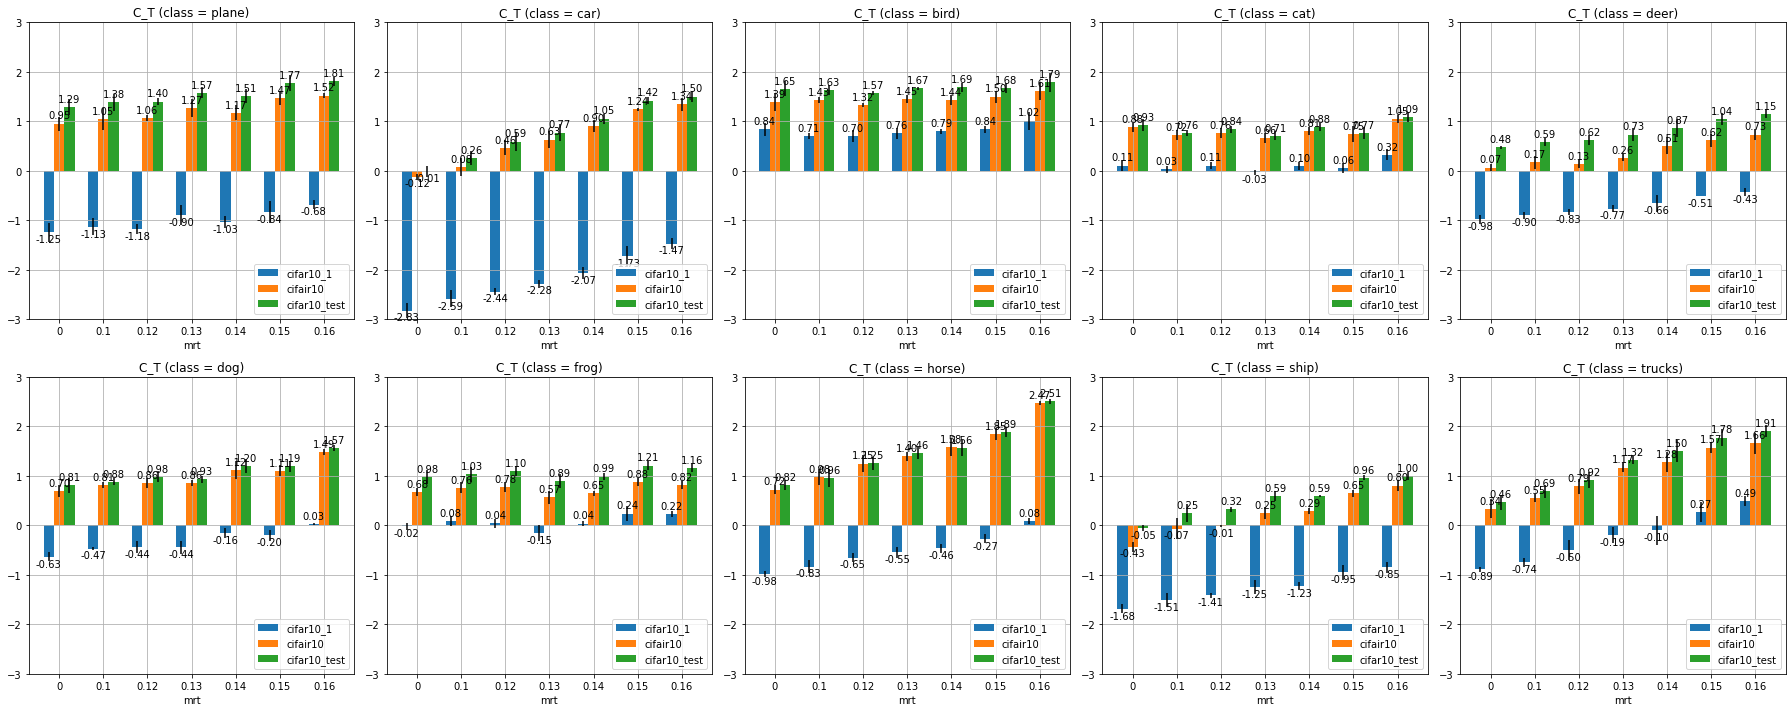

In [28]:
# old biggan image

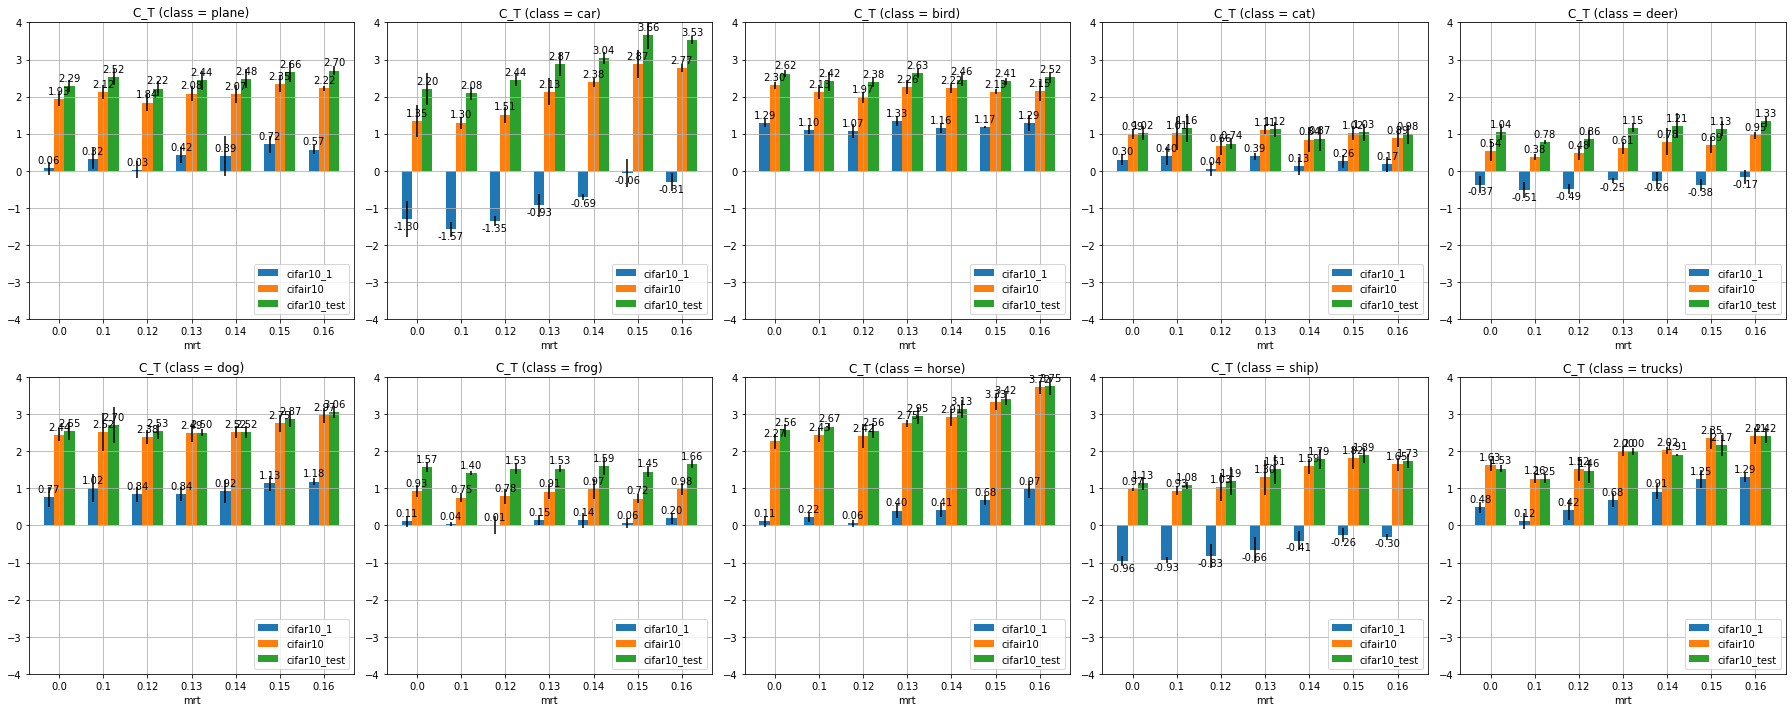

In [47]:
plot_C_T(all_class_stats['sagan'], savefig_fname='data_copying_metrics(cifar10_sagan).pdf')

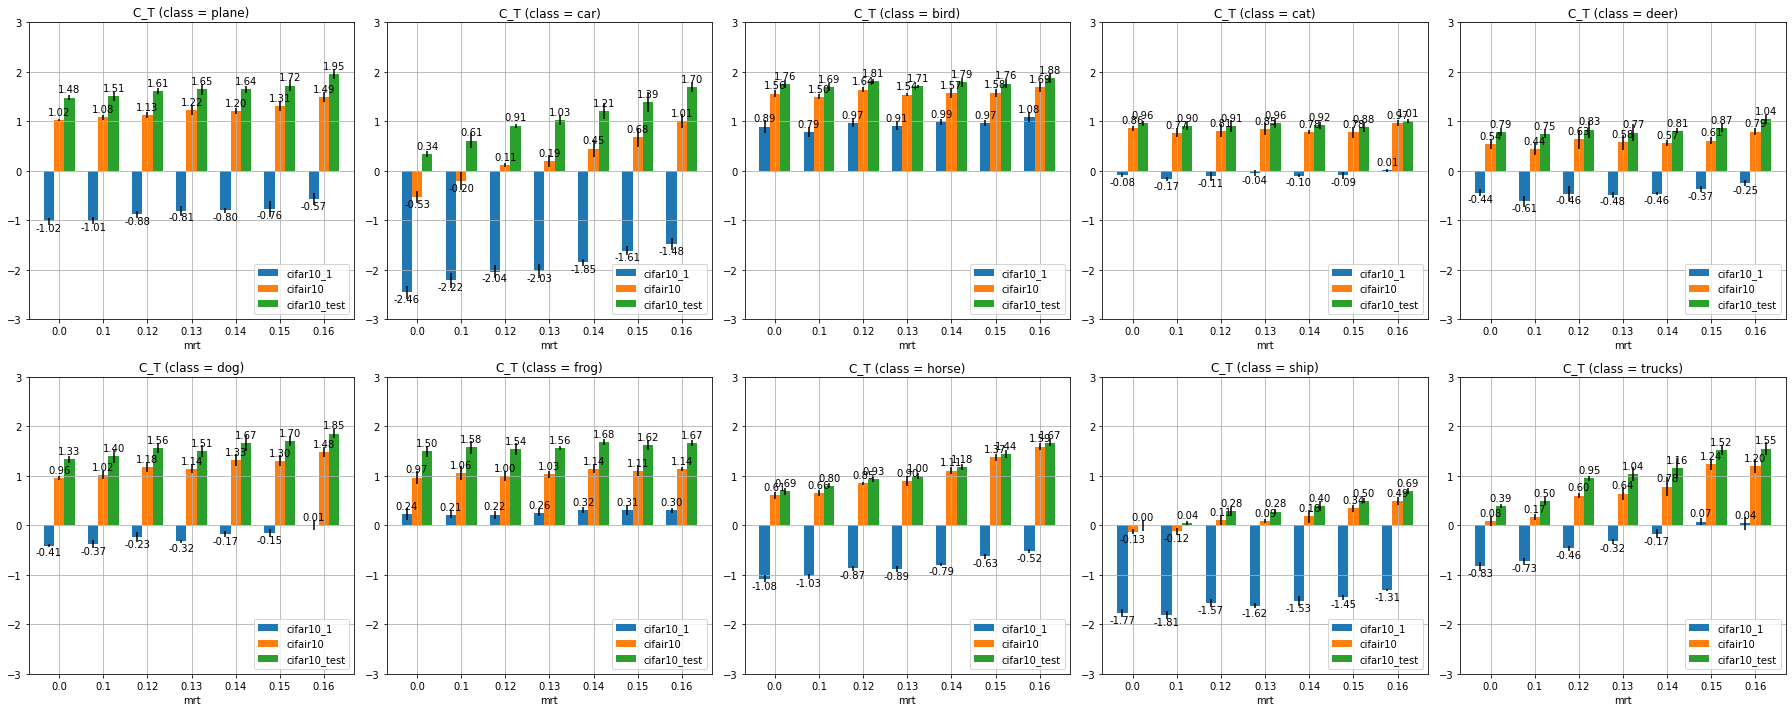

In [48]:
plot_C_T(all_class_stats['diffaug'], savefig_fname='data_copying_metrics(cifar10_diffaug).pdf')

### Generalization of Memorization Rejection

In [16]:
proj_models = {
    'inception_v3': inception.WrappedInception3().eval().to(device),
    'vgg13_bn': vgg.wrapped_vgg13_bn().eval().to(device),
    'alexnet': alexnet.WrappedAlexNet().eval().to(device)
}

##### trainable parameters

#####
##### trainable parameters

#####
##### trainable parameters

#####


In [14]:
all_class_stats = {}

In [19]:
for proj_name, proj_model in proj_models.items():
    for run_name, runs in {'sagan': sagan_runs, 'diffaug': diffaug_runs}.items():
        print(f'{run_name}_{proj_name}')
        all_class_stats[f'{run_name}_{proj_name}'] = calculate_C_T(
            runs, {k: ref_dls[k] for k in ['cifar10_train', 'cifar10_1']}, proj_model)

sagan_inception_v3
n_class = 0
n_class = 1
n_class = 2
n_class = 3
n_class = 4
n_class = 5
n_class = 6
n_class = 7
n_class = 8
n_class = 9
diffaug_inception_v3
n_class = 0
n_class = 1
n_class = 2
n_class = 4
n_class = 5
n_class = 6
n_class = 7
n_class = 8
n_class = 9
sagan_vgg13_bn
n_class = 0
n_class = 1
n_class = 2
n_class = 3
n_class = 4
n_class = 5
n_class = 6
n_class = 7
n_class = 8
n_class = 9
diffaug_vgg13_bn
n_class = 0
n_class = 1
n_class = 2
n_class = 3
n_class = 4
n_class = 5
n_class = 6
n_class = 7
n_class = 8
n_class = 9
sagan_alexnet
n_class = 0
n_class = 1
n_class = 2
n_class = 3
n_class = 4
n_class = 5
n_class = 6
n_class = 7
n_class = 8
n_class = 9
diffaug_alexnet
n_class = 0
n_class = 1
n_class = 2
n_class = 3
n_class = 4
n_class = 5
n_class = 6
n_class = 7
n_class = 8
n_class = 9


In [22]:
if not os.path.isfile('all_C_Ts.pkl'):
    with open('all_C_Ts.pkl', 'wb') as f:
        pickle.dump(all_class_stats, f)

In [48]:
def plot_C_T_intraproj(all_class_stats, gen_model_name, test_dset='cifar10_1', savefig_fname=None):

    selected_keys = [(f"{gen_model_name}_{name}", name) for name in ['vgg13_bn', 'alexnet', 'inception_v3']]
    
    n_proj_model = len(selected_keys)
    width = 0.7 / n_proj_model  # the width of the bars
    x_shifts = np.arange(n_proj_model) * width - (n_proj_model - 1) * width / 2

    fig, axs = plt.subplots(2, 5, figsize=(25, 10))
    
    max_val = 0
        
    classes = sorted(list(list(all_class_stats.values())[0].keys()))
    # mrts = list(list(list(all_class_stats.values())[0].values())[0].keys())
    
    for ax, n_class in zip(axs.flat, classes):

        for x_shift, (total_name, proj_model_name) in zip(x_shifts, selected_keys):
            stats_ = all_class_stats[total_name][n_class][test_dset]
            y = [v['C_T_mean'] for mrt, v in stats_.items()]
            max_val = max(max_val, np.abs(y).max())
            x = np.arange(len(y))
            rects = ax.bar(x + x_shift, y, width,
                           yerr=[v['C_T_std'] for mrt, v in stats_.items()], 
                           label=proj_model_name)

            misc.autolabel(rects, ax)
            ax.set_xticks(x)
            ax.set_xticklabels([mrt for mrt in stats_.keys()])
            ax.set_title(f"C_T (class = {cifar10_classnames[n_class]})")
    
    for ax in axs.flat:
        ax.set_xlabel('mrt')
        ax.set_ylim(-np.ceil(max_val), np.ceil(max_val))
        ax.legend(loc='lower right')
        ax.grid()

    plt.tight_layout()
    if savefig_fname is not None:
        plt.savefig(savefig_fname, bbox_inches='tight')

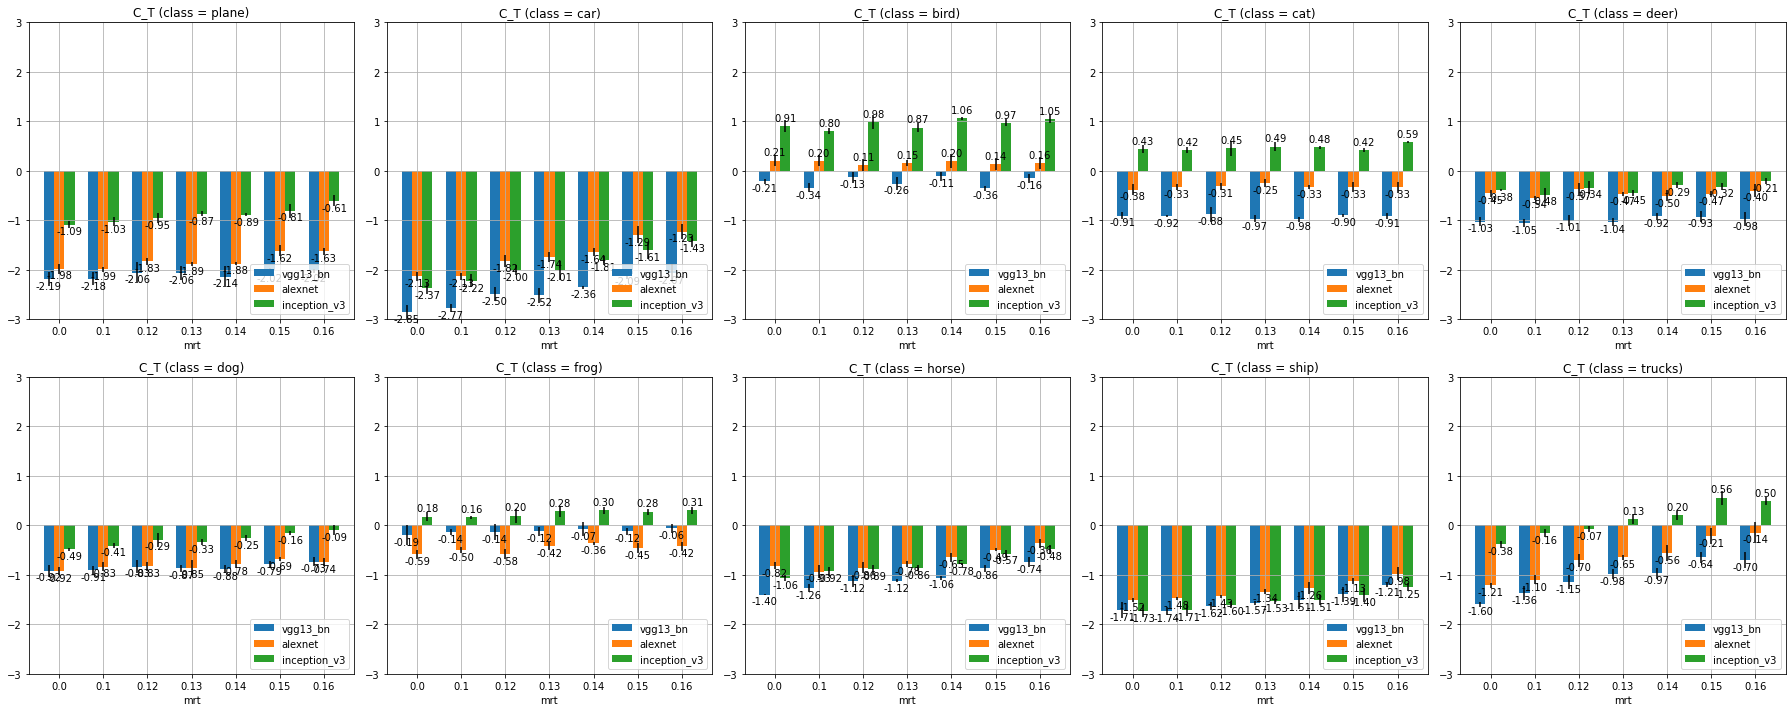

In [49]:
plot_C_T_intraproj(all_class_stats, 'diffaug', savefig_fname='mem_generalization(cifar10_diffaug).pdf')

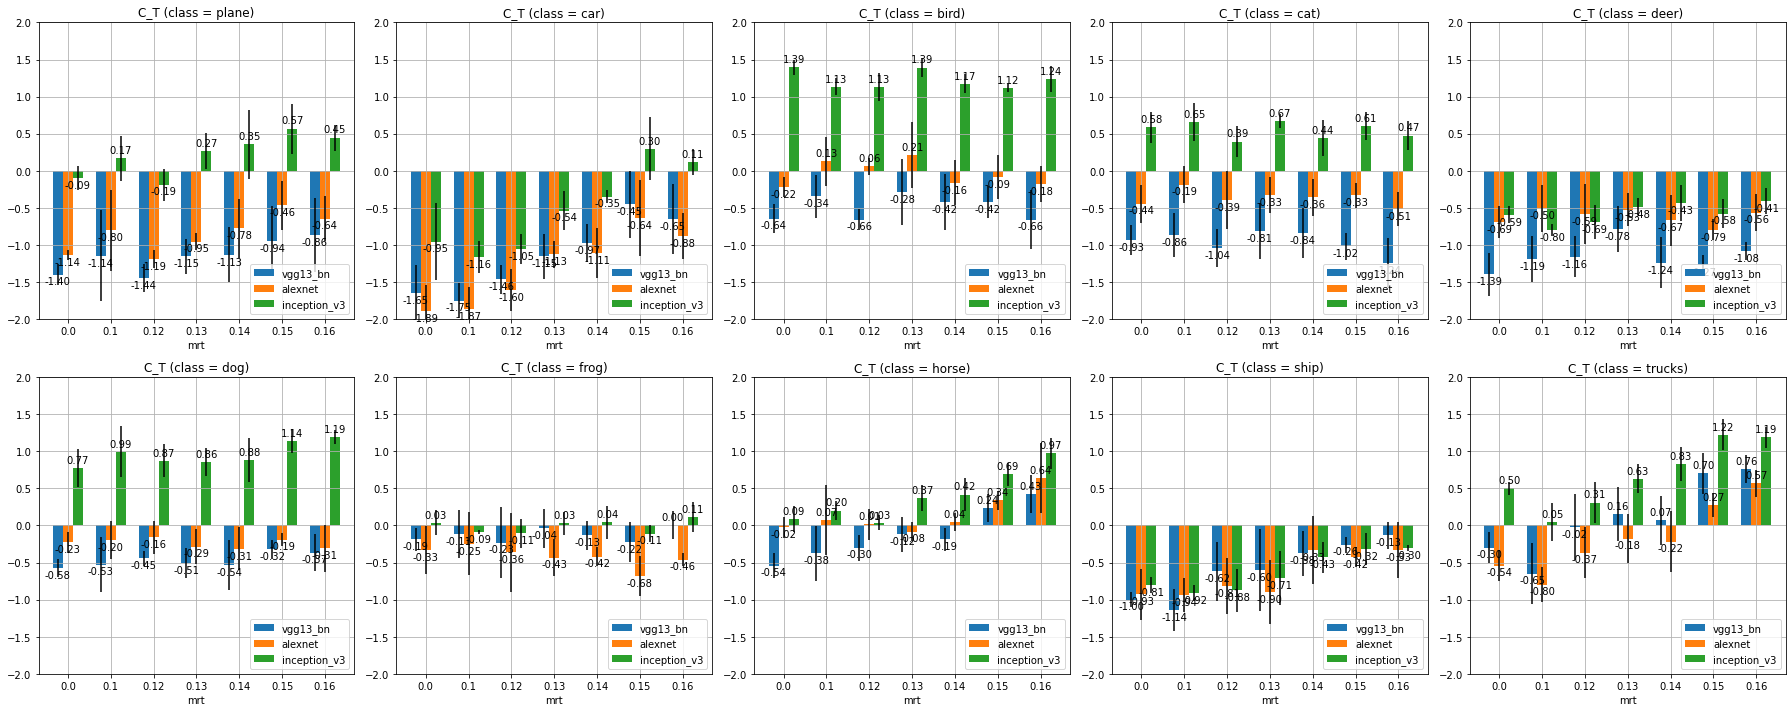

In [50]:
plot_C_T_intraproj(all_class_stats, 'sagan', savefig_fname='mem_generalization(cifar10_sagan).pdf')